In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/resized.zip -d /content/drive/MyDrive/Dataset

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import numpy as np
from PIL import Image
import time
import functools
from tensorflow.keras.preprocessing import image as image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

## **Dataset**

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Dataset/artists.csv')

# Group the data by artist name and collect paintings into a list
grouped = df.groupby('name')['paintings'].apply(list)

# Print each artist with an enumeration and their list of paintings
for index, (artist, paintings) in enumerate(grouped.items(), 1):
    print(f"{index}. {artist}")

1. Albrecht Dürer
2. Alfred Sisley
3. Amedeo Modigliani
4. Andrei Rublev
5. Andy Warhol
6. Camille Pissarro
7. Caravaggio
8. Claude Monet
9. Diego Rivera
10. Diego Velazquez
11. Edgar Degas
12. Edouard Manet
13. Edvard Munch
14. El Greco
15. Eugene Delacroix
16. Francisco Goya
17. Frida Kahlo
18. Georges Seurat
19. Giotto di Bondone
20. Gustav Klimt
21. Gustave Courbet
22. Henri Matisse
23. Henri Rousseau
24. Henri de Toulouse-Lautrec
25. Hieronymus Bosch
26. Jackson Pollock
27. Jan van Eyck
28. Joan Miro
29. Kazimir Malevich
30. Leonardo da Vinci
31. Marc Chagall
32. Michelangelo
33. Mikhail Vrubel
34. Pablo Picasso
35. Paul Cezanne
36. Paul Gauguin
37. Paul Klee
38. Peter Paul Rubens
39. Pierre-Auguste Renoir
40. Piet Mondrian
41. Pieter Bruegel
42. Raphael
43. Rembrandt
44. Rene Magritte
45. Salvador Dali
46. Sandro Botticelli
47. Titian
48. Vasiliy Kandinskiy
49. Vincent van Gogh
50. William Turner


In [ ]:
content_path = '/content/miasto.jpg'

artist_number = 49

In [ ]:
import random

# Retrieve selected artist's data
selected_artist = grouped.iloc[artist_number - 1]

# Randomly choose a painting from the selected artist's list
painting_count = selected_artist[0]
random_index = random.randint(0, painting_count - 1)  # Adjusted to start index from 0

# Get the artist's name from the index of the grouped Series
artist_name = "_".join(grouped.index[artist_number - 1].split())
style_path = '/content/style.jpeg'
#f'/content/drive/MyDrive/Dataset/resized/{artist_name}_{149}.jpg'

print(f"Selected Painting Path: {style_path}")

Selected Painting Path: /content/style.jpeg


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img = image.img_to_array(img)

  # We need to broadcast the image array such that it has a batch dimension
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display
  out = out.astype('uint8')
  plt.imshow(out)
  if title:
     plt.title(title)
  plt.imshow(out)

<ipython-input-28-3af835e36c32>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


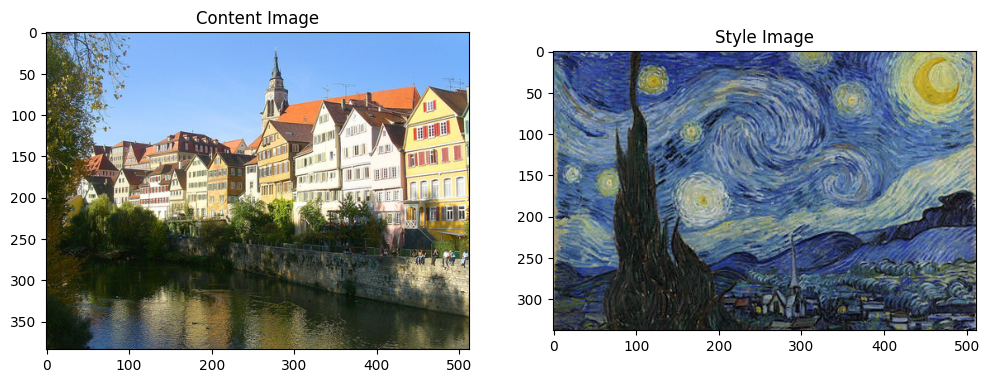

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## **Model**

In [ ]:
resnet = tf.keras.applications.ResNet101(include_top=False, weights='imagenet')
resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['conv1_conv']

# Style layer we are interested in
style_layers = ['conv2_block1_1_bn','conv2_block2_3_bn','conv2_block1_0_bn','conv4_block5_2_bn' ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def resnet_layers():
  # Loading the model. We loaded pretrained ResNet101, trained on imagenet data
  resnet = tf.keras.applications.ResNet101(include_top=False, weights='imagenet')
  resnet.trainable = False

  style_outputs = [resnet.get_layer(name).output for name in style_layers]
  content_outputs = [resnet.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(resnet.input, model_outputs)

In [ ]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.resnet.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)

  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  #adjusting color channels by adding specific mean values and reversing the channel order from RGB to BGR
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
  # Reshape the input tensor to have channels first, then compute the Gram matrix
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [ ]:
def get_feature_representations(model, content_path, style_path):
  # Load our images in
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)


  # Get the style and content feature representations from our model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights

  # Feed our init image through our model. This will give us the content and
  # style representations at our desired layers.
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # Accumulate content losses from all layers
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score
  return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  # Compute gradients with respect to input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
import IPython.display
from tensorflow.keras.optimizers import Adam

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=1,
                       style_weight=1e7):
  # No need to train layers of the model
  model = resnet_layers()
  for layer in model.layers:
    layer.trainable = False

  # Get the style and content feature representations (from our specified intermediate layers)
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=20)

  # Store our best result
  best_loss, best_img = float('inf'), None

  # Create a configuration dictionary
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  # results display settings
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()

    print(". ", end="") # For tracking progress

    if loss < best_loss:
      # Update best loss and best image from total loss.
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()

      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      print('Total loss: {:.4e}, '
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss

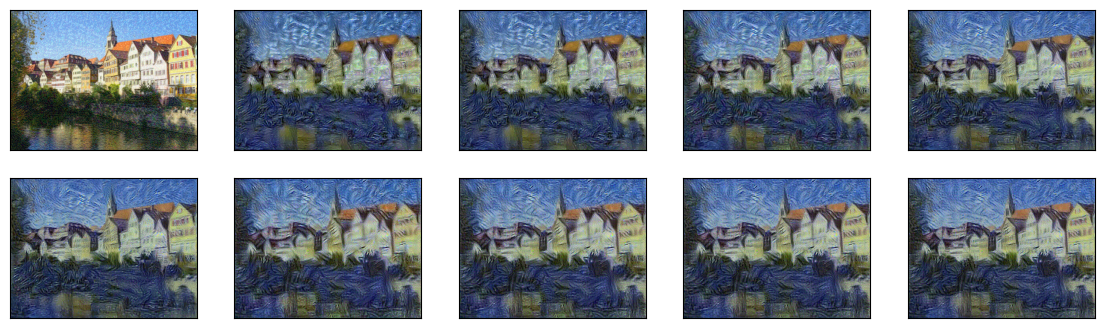

In [ ]:
best, best_loss = run_style_transfer(content_path,
                                     style_path, num_iterations=1000)

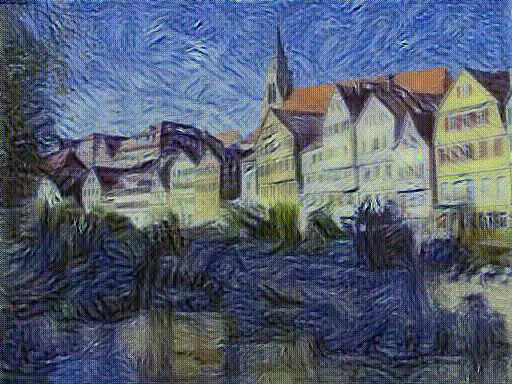

In [ ]:
Image.fromarray(best)

In [ ]:
Image.fromarray(best).save("out.jpg", "JPEG", quality=80, optimize=True, progressive=True)

# downloading result images from colab
from google.colab import files
files.download('out.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path)
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final:
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)